# To be run on Colab

<span style="color:orange"> Modifications are necessary to run on pc </span>

### Downloading the validation set for some sample images.

In [ ]:
! unzip "/content/drive/MyDrive/Exploratory reading/Papers/VisDrone2019-DET-val.zip"

### Cloning EdgeYolo repository

In [ ]:
! git clone https://github.com/LSH9832/edgeyolo.git

In [ ]:
! cd edgeyolo ; pip install -r requirements.txt

### Downloading pretrained weights

In [ ]:
! wget https://github.com/LSH9832/edgeyolo/releases/download/v0.0.0/edgeyolo_visdrone.pth

## Demo of the model

<div align="center">

| Index | Class names |
| -----: | ----------- |
| 0 | pedestrian |
| 1 | people |
| 2 | bicycle |
| 3 | car |
| 4 | van |
| 5 | truck |
| 6 | tricycle |
| 7 | awning-tricycle |
| 8 | bus |
  9 | motor |
</div>

For final result to only have bounding boxes for requested classes, a list of class indices can be set for `MyArguments.classes`. Or can be set to be `None` for results for all classes

Example : 
~~~python
 MyArguments.classes = [0,2] # for indentifying pedestrian and bicycle. 
 ~~~

Making a folder for example images

In [16]:
! cp "/content/VisDrone2019-DET-val/images/0000330_01601_d_0000808.jpg" /content/fewImgs/
! cp "/content/VisDrone2019-DET-val/images/0000129_02411_d_0000138.jpg" /content/fewImgs/

2023-10-15 10:31:57.437 | INFO     | edgeyolo.edgeyolo.models:__init__:50 - loading models from weight /content/edgeyolo_visdrone.pth


Params: 41.18M, Gflops: 126.41
Reparameterizing models...
After re-parameterization: Params: 40.46M, Gflops: 124.40
/content/fewImgs/0000129_02411_d_0000138.jpg
59.0ms  average:59.0ms      

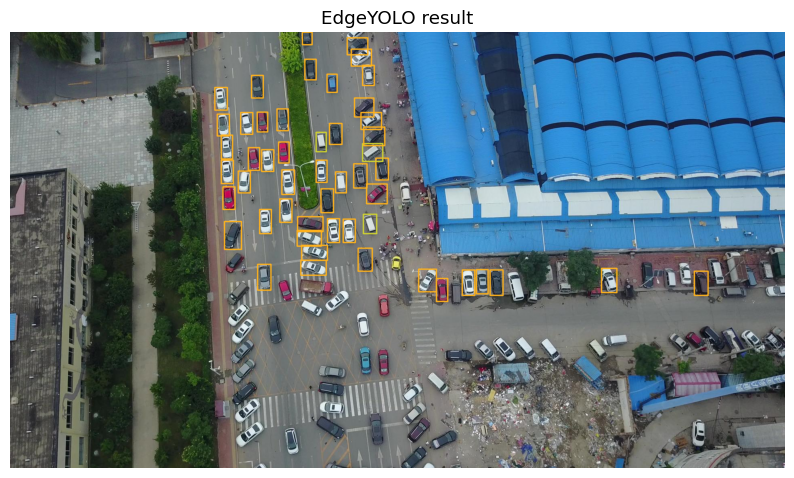

/content/fewImgs/0000330_01601_d_0000808.jpg
61.4ms  average:60.2ms      

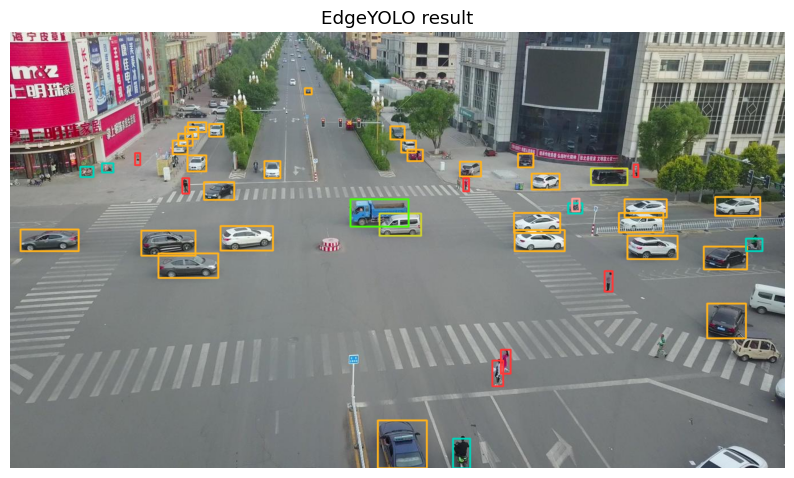

2023-10-15 10:32:00.738 | INFO     | __main__:detect_single:164 - 
total frame: 2, total average latency: 598.480152130127ms


In [17]:
from torch.serialization import SourceChangeWarning
from torch import max_pool1d
from multiprocessing import Process, Manager, freeze_support
from datetime import datetime as date
from loguru import logger

from glob import glob

import torch.cuda
import argparse
import cv2
import os

from edgeyolo.edgeyolo.detect import Detector, TRTDetector, draw


  ##################~~~~~~~~ EDITS ~~~~~~~~####################
class MyArguments():
    def __init__(self):
      self.weights = "/content/edgeyolo_visdrone.pth"
      self.conf_thres = 0.45
      self.nms_thres = 0.55
      self.mp = False
      self.fp16 = False
      self.no_fuse = False
      self.input_size = [640, 640]
      self.source = "/content/fewImgs"
      self.trt = False
      self.legacy = False
      self.use_decoder = False
      self.batch = 1
      self.no_label = False
      self.save_dir = "./output/detect/imgs/"
      self.fps = 99999
      self.classes = None#[1,3,0]

%matplotlib inline
def show_image(ttl, img):
      import matplotlib.pyplot as plt
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      plt.figure(figsize=(10, 10))
      plt.imshow(img)
      plt.axis('off')
      plt.title(ttl)
      plt.show()

def get_spec_result(results,spec_classes):
      if spec_classes is not None :
          from numpy import isin
          for result in results:
            if result is not None:
              mask = isin(result[:,6],spec_classes)
              results.append(result[mask])
              results = results[1:]
      return results
  ##################~~~~ FINISH EDITS ~~~~~####################


def detect_single(args):
    import time
    exist_save_dir = os.path.isdir(args.save_dir)

    # detector setup
    detector = TRTDetector if args.trt else Detector
    detect = detector(
        weight_file=args.weights,
        conf_thres=args.conf_thres,
        nms_thres=args.nms_thres,
        input_size=args.input_size,
        fuse=not args.no_fuse,
        fp16=args.fp16,
        use_decoder=args.use_decoder
    )
    if args.trt:
        args.batch = detect.batch_size

    # source loader setup
    if os.path.isdir(args.source):

        class DirCapture:

            def __init__(self, dir_name):
                self.imgs = []
                for img_type in ["jpg", "png", "jpeg", "bmp", "webp"]:
                    self.imgs += sorted(glob(os.path.join(dir_name, f"*.{img_type}")))

            def isOpened(self):
                return bool(len(self.imgs))

            def read(self):
                print(self.imgs[0])
                now_img = cv2.imread(self.imgs[0])
                self.imgs = self.imgs[1:]
                return now_img is not None, now_img

        source = DirCapture(args.source)
        delay = 0
    else:
        source = cv2.VideoCapture(int(args.source) if args.source.isdigit() else args.source)
        delay = 1

    all_dt = []
    dts_len = 300 // args.batch
    success = True

    # start inference
    count = 0
    t_start = time.time()
    while source.isOpened() and success:

        frames = []
        for _ in range(args.batch):
            success, frame = source.read()
            if not success:
                if not len(frames):
                    cv2.destroyAllWindows()
                    break
                else:
                    while len(frames) < args.batch:
                        frames.append(frames[-1])
            else:
                frames.append(frame)

        if not len(frames):
            break

        results = detect(frames, args.legacy)
        dt = detect.dt
        all_dt.append(dt)
        if len(all_dt) > dts_len:
            all_dt = all_dt[-dts_len:]
        print(f"\r{dt * 1000 / args.batch:.1f}ms  "
              f"average:{sum(all_dt) / len(all_dt) / args.batch * 1000:.1f}ms", end="      ")

        key = -1

        # [print(result.shape) for result in results]

        results = get_spec_result(results,args.classes)

        imgs = draw(frames, results, detect.class_names, 2, draw_label=not args.no_label)
        # print([im.shape for im in frames])
        for img in imgs:
            # print(img.shape)
            show_image("EdgeYOLO result", img)
            count += 1

            key = cv2.waitKey(delay)
            if key in [ord("q"), 27]:
                break
            elif key == ord(" "):
                delay = 1 - delay
            elif key == ord("s"):
                if not exist_save_dir:
                    os.makedirs(args.save_dir, exist_ok=True)
                    exist_save_dir = True
                file_name = f"{str(date.now()).split('.')[0].replace(':', '').replace('-', '').replace(' ', '')}.jpg"
                cv2.imwrite(os.path.join(args.save_dir, file_name), img)
                logger.info(f"image saved to {file_name}.")
        if key in [ord("q"), 27]:
            cv2.destroyAllWindows()
            break

    logger.info(f"\ntotal frame: {count}, total average latency: {(time.time() - t_start) * 1000 / count - 1}ms")

opt = MyArguments()
detect_single(opt)